# Baseline

## Klasyfikacja binarna mowy nienawiści (toxic vs non-toxic)

**Baseline:** TF-IDF (uni+bi) → Regresja logistyczna / Linear SVM

**Metryki:** Accuracy, Macro F1, ROC-AUC + macierz pomyłek

In [5]:
# Imports i konfiguracja
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, f1_score, accuracy_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay
)

SEED = 42
np.random.seed(SEED)

# Etykiety do przewidywania: toxic i severe_toxic
LABELS = ["toxic", "severe_toxic"]
TEXT_COL = "comment_text"
ID_COL = "id"

In [6]:
# Wczytanie danych
train_path = "../data/df_train.csv"
val_path = "../data/df_val.csv"
test_path = "../data/raw/test.csv"
test_labels_path = "../data/raw/test_labels.csv"

df_train = pd.read_csv(train_path)
df_val = pd.read_csv(val_path)

# Test: merge tekstu i etykiet, odfiltruj -1 (brak etykiety)
df_test_text = pd.read_csv(test_path)
df_test_labels = pd.read_csv(test_labels_path)
df_test = df_test_text.merge(df_test_labels, on=ID_COL, how="inner")
mask_valid = (df_test[LABELS] >= 0).all(axis=1)
df_test = df_test.loc[mask_valid].reset_index(drop=True)

# Przekształć na klasyfikację multi-label: toxic i severe_toxic
for df in (df_train, df_val, df_test):
    df[TEXT_COL] = df[TEXT_COL].fillna("")

print("Shapes:")
for label in LABELS:
    print(f"  train {label}: {df_train[label].sum()} ({df_train[label].mean():.1%})")
    print(f"  val   {label}: {df_val[label].sum()} ({df_val[label].mean():.1%})")
    print(f"  test  {label}: {df_test[label].sum()} ({df_test[label].mean():.1%})")
print(f"  train: {df_train.shape}")
print(f"  val:   {df_val.shape}")
print(f"  test:  {df_test.shape}")

# Check wycieku ID
ids_train, ids_val, ids_test = set(df_train[ID_COL]), set(df_val[ID_COL]), set(df_test[ID_COL])
print(f"\nID Intersections: train∩val={len(ids_train & ids_val)}, train∩test={len(ids_train & ids_test)}, val∩test={len(ids_val & ids_test)}")

Shapes:
  train toxic: 1881 (9.4%)
  val   toxic: 187 (9.3%)
  test  toxic: 6090 (9.5%)
  train severe_toxic: 179 (0.9%)
  val   severe_toxic: 29 (1.5%)
  test  severe_toxic: 367 (0.6%)
  train: (20000, 8)
  val:   (2000, 8)
  test:  (63978, 8)

ID Intersections: train∩val=0, train∩test=0, val∩test=0


In [7]:
# Definicja modelu baseline
from sklearn.multiclass import OneVsRestClassifier

CLASSIFIER = "logreg"  # "logreg" | "linear_svc"

tfidf = TfidfVectorizer(
    lowercase=True,
    strip_accents="unicode",
    ngram_range=(1, 2),
    min_df=2,
    max_features=200_000,
)

if CLASSIFIER == "logreg":
    clf = LogisticRegression(
        solver="liblinear",
        class_weight="balanced",
        C=2.0,
        max_iter=400,
    )
elif CLASSIFIER == "linear_svc":
    clf = LinearSVC(
        class_weight="balanced",
        C=2.0,
        max_iter=2000,
    )
else:
    raise ValueError("Unknown CLASSIFIER")

pipe = Pipeline([("tfidf", tfidf), ("clf", OneVsRestClassifier(clf))])

In [8]:
# Trenowanie na zbiorze treningowym
X_train = df_train[TEXT_COL]
y_train = df_train[LABELS].values
X_val = df_val[TEXT_COL]
y_val = df_val[LABELS].values
X_test = df_test[TEXT_COL]
y_test = df_test[LABELS].values

pipe.fit(X_train, y_train)
print("Model trained on", len(X_train), "samples")

Model trained on 20000 samples


In [10]:
# Ewaluacja na walidacji
y_val_pred = pipe.predict(X_val)
y_val_prob = pipe.predict_proba(X_val)  # Shape: (n_samples, n_labels)

val_acc = accuracy_score(y_val, y_val_pred)  # Exact match accuracy
val_f1 = f1_score(y_val, y_val_pred, average="macro")
val_auc = roc_auc_score(y_val, y_val_prob, average="macro")

print("Validation per label:")
for i, label in enumerate(LABELS):
    print(f"  {label}:")
    print(classification_report(y_val[:, i], y_val_pred[:, i], target_names=[f"non-{label}", label], digits=4))

print(f"Overall - Exact Match Acc: {val_acc:.4f}, Macro F1: {val_f1:.4f}, Macro ROC-AUC: {val_auc:.4f}")

Validation per label:
  toxic:
              precision    recall  f1-score   support

   non-toxic     0.9749    0.9641    0.9695      1813
       toxic     0.6860    0.7594    0.7208       187

    accuracy                         0.9450      2000
   macro avg     0.8304    0.8618    0.8452      2000
weighted avg     0.9479    0.9450    0.9462      2000

  severe_toxic:
                  precision    recall  f1-score   support

non-severe_toxic     0.9954    0.9878    0.9916      1971
    severe_toxic     0.4545    0.6897    0.5479        29

        accuracy                         0.9835      2000
       macro avg     0.7250    0.8387    0.7698      2000
    weighted avg     0.9876    0.9835    0.9852      2000

Overall - Exact Match Acc: 0.9295, Macro F1: 0.6344, Macro ROC-AUC: 0.9483


In [11]:
# Ewaluacja na teście
y_test_pred = pipe.predict(X_test)
y_test_prob = pipe.predict_proba(X_test)

test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average="macro")
test_auc = roc_auc_score(y_test, y_test_prob, average="macro")

print("Test per label:")
for i, label in enumerate(LABELS):
    print(f"  {label}:")
    print(classification_report(y_test[:, i], y_test_pred[:, i], target_names=[f"non-{label}", label], digits=4))

print(f"Overall - Exact Match Acc: {test_acc:.4f}, Macro F1: {test_f1:.4f}, Macro ROC-AUC: {test_auc:.4f}")

Test per label:
  toxic:
              precision    recall  f1-score   support

   non-toxic     0.9721    0.9281    0.9496     57888
       toxic     0.5223    0.7470    0.6148      6090

    accuracy                         0.9109     63978
   macro avg     0.7472    0.8375    0.7822     63978
weighted avg     0.9293    0.9109    0.9177     63978

  severe_toxic:
                  precision    recall  f1-score   support

non-severe_toxic     0.9979    0.9839    0.9909     63611
    severe_toxic     0.1883    0.6485    0.2918       367

        accuracy                         0.9819     63978
       macro avg     0.5931    0.8162    0.6414     63978
    weighted avg     0.9933    0.9819    0.9868     63978

Overall - Exact Match Acc: 0.8950, Macro F1: 0.4533, Macro ROC-AUC: 0.9537


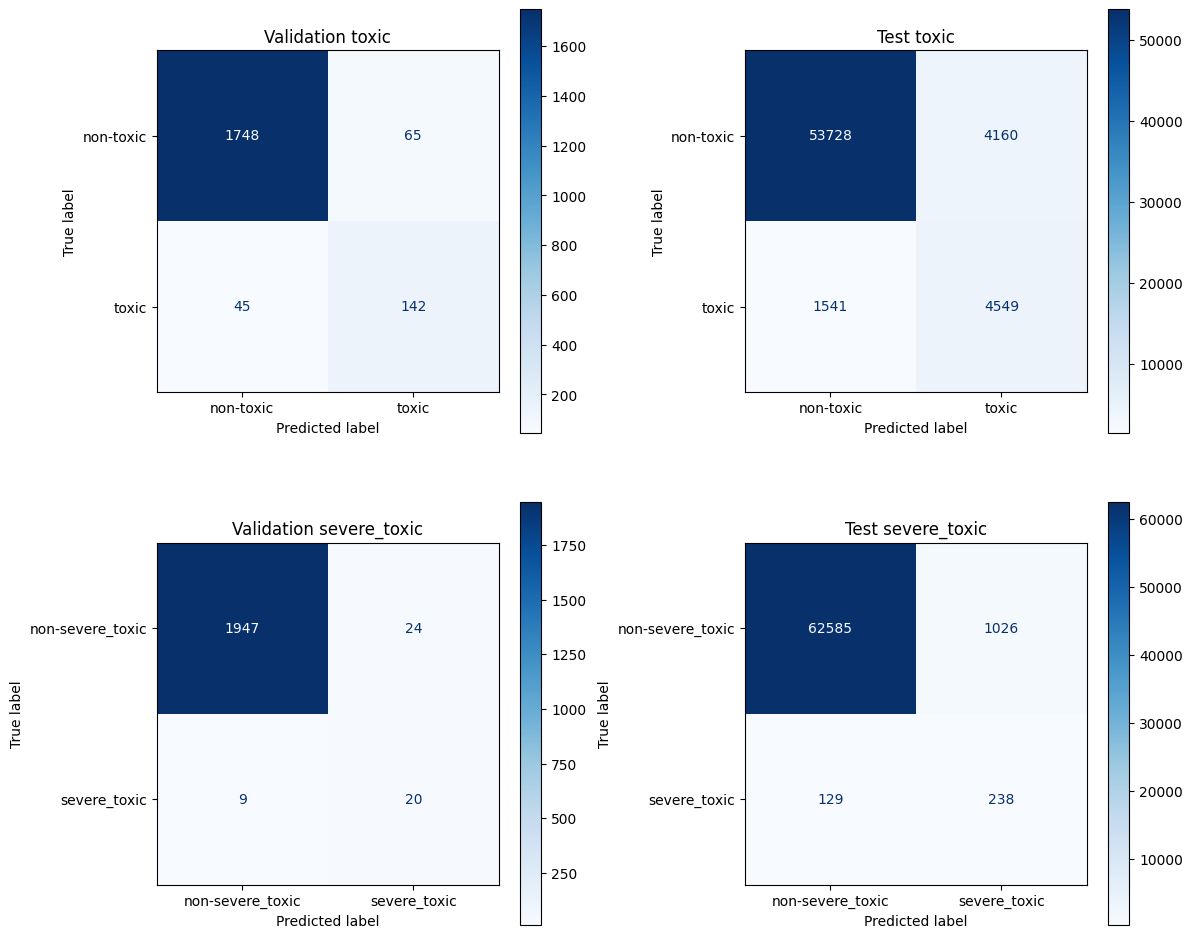

In [12]:
# Macierze pomyłek
import pathlib
reports_dir = pathlib.Path("../reports")
reports_dir.mkdir(parents=True, exist_ok=True)

fig, axes = plt.subplots(len(LABELS), 2, figsize=(12, 5 * len(LABELS)))

for i, label in enumerate(LABELS):
    # VAL
    cm_val = confusion_matrix(y_val[:, i], y_val_pred[:, i])
    disp_val = ConfusionMatrixDisplay(cm_val, display_labels=[f"non-{label}", label])
    disp_val.plot(ax=axes[i, 0], cmap="Blues", values_format="d")
    axes[i, 0].set_title(f"Validation {label}")

    # TEST
    cm_test = confusion_matrix(y_test[:, i], y_test_pred[:, i])
    disp_test = ConfusionMatrixDisplay(cm_test, display_labels=[f"non-{label}", label])
    disp_test.plot(ax=axes[i, 1], cmap="Blues", values_format="d")
    axes[i, 1].set_title(f"Test {label}")

plt.tight_layout()
plt.savefig(reports_dir / "confusion_matrix.png", dpi=150, bbox_inches="tight")
plt.show()

In [13]:
# Zapisz metryki do JSON
metrics = {
    "task": "multi_label_binary_classification",
    "dataset": "Jigsaw Toxic Comment (Wikipedia)",
    "labels": LABELS,
    "model": {
        "type": CLASSIFIER,
        "classifier": str(clf.__class__.__name__),
        "C": getattr(clf, "C", None),
        "class_weight": getattr(clf, "class_weight", None),
    },
    "vectorizer": {
        "type": "TF-IDF",
        "ngram_range": list(tfidf.ngram_range),
        "max_features": tfidf.max_features,
        "min_df": tfidf.min_df,
    },
    "val": {
        "exact_match_accuracy": float(val_acc),
        "macro_f1": float(val_f1),
        "macro_roc_auc": float(val_auc),
    },
    "test": {
        "exact_match_accuracy": float(test_acc),
        "macro_f1": float(test_f1),
        "macro_roc_auc": float(test_auc),
    },
}

with open(reports_dir / "metrics_baseline.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2)

print(f"  Val  - Exact Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")
print(f"  Test - Exact Acc: {test_acc:.4f}, F1: {test_f1:.4f}, AUC: {test_auc:.4f}")

  Val  - Exact Acc: 0.9295, F1: 0.6344, AUC: 0.9483
  Test - Exact Acc: 0.8950, F1: 0.4533, AUC: 0.9537


In [15]:
# Porównanie modeli: LogReg vs LinearSVC (z różnymi C)
from sklearn.base import clone

def eval_model(model_name, clf, X_train, y_train, X_val, y_val):
    vec = TfidfVectorizer(lowercase=True, strip_accents="unicode", ngram_range=(1,2), min_df=2, max_features=200_000)
    pipe = Pipeline([("tfidf", vec), ("clf", OneVsRestClassifier(clone(clf)))])
    pipe.fit(X_train, y_train)
    
    y_pred = pipe.predict(X_val)
    if hasattr(pipe, 'predict_proba'):
        y_prob = pipe.predict_proba(X_val)
    else:
        y_prob = pipe.decision_function(X_val)
    
    return {
        "model": model_name,
        "exact_match_accuracy": accuracy_score(y_val, y_pred),
        "macro_f1": f1_score(y_val, y_pred, average="macro"),
        "macro_roc_auc": roc_auc_score(y_val, y_prob, average="macro"),
    }

results = []
for model_name, base, Cs in [
    ("LogReg", LogisticRegression(solver="liblinear", class_weight="balanced", max_iter=400), [0.5, 1.0, 2.0]),
    ("LinearSVC", LinearSVC(class_weight="balanced", max_iter=2000), [0.5, 1.0, 2.0]),
]:
    for C in Cs:
        clf_test = clone(base)
        clf_test.C = C
        res = eval_model(f"{model_name} C={C}", clf_test, X_train, y_train, X_val, y_val)
        results.append(res)

df_comparison = pd.DataFrame(results).sort_values("macro_f1", ascending=False)
print("Model Comparison (sorted by Macro F1):")
df_comparison

Model Comparison (sorted by Macro F1):


,model,exact_match_accuracy,macro_f1,macro_roc_auc
3,LinearSVC C=0.5,0.9455,0.663889,0.941797
4,LinearSVC C=1.0,0.9480,0.653123,0.937069
5,LinearSVC C=2.0,0.9470,0.639881,0.931669
2,LogReg C=2.0,0.9295,0.634379,0.948320
1,LogReg C=1.0,0.9200,0.610245,0.947867
0,LogReg C=0.5,0.9110,0.584909,0.945234
